# S&P 500 Index Constituents

In [215]:
import numpy as np
import pandas as pd
import datetime as datetime
from datetime import datetime
import requests
import os
import json
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [216]:
load_dotenv()

True

In [217]:
# Read in API key from env file
FMP_API_KEY = os.getenv('FMP_API_KEY')

In [218]:
# Pull S&P 500 constituents (need subscription for premium endpoints)
url = f'https://financialmodelingprep.com/api/v3/sp500_constituent?apikey={FMP_API_KEY}'
sp_index = requests.get(url).json()
sp_index = pd.DataFrame(sp_index)
sp_index.to_csv('resources/sp_index.csv')
sp_index.head()

,symbol,name,sector,subSector,headQuarter,dateFirstAdded,cik,founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,0000066740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,0000091142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,0000001800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,0001551152,2013
4,ABMD,Abiomed,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,0000815094,1981


In [219]:
# Verify how many companies are in the S&P 500 index
sp_index.count()

symbol            504
name              504
sector            504
subSector         504
headQuarter       504
dateFirstAdded    504
cik               504
founded           504
dtype: int64

In [220]:
# Pull market_cap and dcf valuation data for each company (you may pull additional company data as needed - see docs for API endpoints)
company_data = {}

for company in sp_index['symbol']:

    company_data[company] = {}

    market_cap = requests.get(f'https://financialmodelingprep.com/api/v3/market-capitalization/{company}?period=quarter&limit=2&apikey={FMP_API_KEY}').json()
    company_data[company]['market_cap'] = market_cap[0]['marketCap']
    
    dcf = requests.get(f'https://financialmodelingprep.com/api/v3/discounted-cash-flow/{company}?&apikey={FMP_API_KEY}').json()
    company_data[company]['date'] = dcf[0]['date']
    company_data[company]['stock_price'] = dcf[0]['Stock Price']
    company_data[company]['fmp_dcf_calc'] = dcf[0]['dcf'] # DCF calculation by FMP API 

In [221]:
# Create dataframe of requested company data, rename column, save .csv file
company_data = pd.DataFrame(company_data).T.reset_index()
company_data = company_data.rename(columns={'Unnamed: 0':'symbol'})
company_data['margin_of_safety'] = (company_data['fmp_dcf_calc'] - company_data['stock_price']) / company_data['stock_price']
company_data.T.to_csv('resources/company_data.csv')
company_data.head()

,index,market_cap,date,stock_price,fmp_dcf_calc,margin_of_safety
0,MMM,84266262528,2022-05-04,148.08,155.877711,0.052659
1,AOS,9280059392,2022-05-04,59.1,61.826255,0.04613
2,ABT,198268059648,2022-05-04,112.43,117.916562,0.0488
3,ABBV,264235483136,2022-05-04,149.6,155.121398,0.036908
4,ABMD,13019949056,2022-05-04,285.87,288.777956,0.010172


In [222]:
# Concat S&P 500 constituents dataframe and requested company data, calculate total market cap 
sp_index_combined = pd.concat([sp_index, company_data],axis=1)
sp_index_combined = sp_index_combined.T.drop_duplicates().T.set_index('symbol')

sp_total_cap = sp_index_combined['market_cap'].sum()
print(f'S&P 500 Total Market Cap = {sp_total_cap}')

sp_index_combined['% weight'] = sp_index_combined['market_cap'] / sp_total_cap
sp_index_combined.to_csv('resources/sp_index_combined.csv')

S&P 500 Total Market Cap = 39113153244672


In [223]:
# Sort dataframe by % weight
sp_index_combined = sp_index_combined.sort_values(by=['% weight'], ascending=False)
sp_index_combined.head(10)

,name,sector,subSector,headQuarter,dateFirstAdded,cik,founded,market_cap,date,stock_price,fmp_dcf_calc,margin_of_safety,% weight
symbol,,,,,,,,,,,,,
AAPL,Apple,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,0000320193,1977,2602617798656,2022-05-04,159.48,161.551756,0.012991,0.066541
MSFT,Microsoft,Information Technology,Systems Software,"Redmond, Washington",1994-06-01,0000789019,1975,2107441020928,2022-05-04,281.78,283.324164,0.00548,0.053881
GOOG,Alphabet (Class C),Communication Services,Interactive Media & Services,"Mountain View, California",2006-04-03,0001652044,1998,1551770451968,2022-05-04,2362.59,2393.549958,0.013104,0.039674
GOOGL,Alphabet (Class A),Communication Services,Interactive Media & Services,"Mountain View, California",2014-04-03,0001652044,1998,1548909674496,2022-05-04,2346.68,2377.587191,0.013171,0.039601
AMZN,Amazon,Consumer Discretionary,Internet & Direct Marketing Retail,"Seattle, Washington",2005-11-18,0001018724,1994,1264204906496,2022-05-04,2485.07,2556.089608,0.028579,0.032322
TSLA,Tesla,Consumer Discretionary,Automobile Manufacturers,"Palo Alto, California",2020-12-21,0001318605,2003,941992050688,2022-05-04,909.25,925.434375,0.0178,0.024084
BRK-B,Berkshire Hathaway,Financials,Multi-Sector Holdings,"Omaha, Nebraska",2010-02-16,0001067983,1839,705395359744,2022-05-04,318.99,355.860809,0.115586,0.018035
FB,Meta,Communication Services,Interactive Media & Services,"Menlo Park, California",2013-12-23,0001326801,2004,573821026304,2022-05-04,212.03,217.836576,0.027386,0.014671
NVDA,Nvidia,Information Technology,Semiconductors,"Santa Clara, California",2001-11-30,0001045810,1993,488481849344,2022-05-04,196.02,196.801925,0.003989,0.012489


In [224]:
# Change columns dtypes
data_types_dict = {'cik':int,'market_cap':float,'stock_price':float,'fmp_dcf_calc':float,'margin_of_safety':float,'% weight':float}
sp_index_combined = sp_index_combined.astype(data_types_dict)
sp_index_combined['date'] = pd.to_datetime(sp_index_combined['date'].astype(str), format='%Y/%m/%d')
sp_index_combined['dateFirstAdded'] = pd.to_datetime(sp_index_combined['dateFirstAdded'].astype(str), format='%Y/%m/%d')
sp_index_combined['dateFirstAdded'] = sp_index_combined['dateFirstAdded'].replace({pd.NaT:None})

In [225]:
# Sort by % weight and by sector
sp_index_combined.groupby(by=['sector','name']).sum().sort_values(by='market_cap', ascending=False).drop(columns=['cik','stock_price','fmp_dcf_calc']).head(10)

market_cap  margin_of_safety  \
sector                 name                                                 
Information Technology Apple               2.602618e+12          0.012991   
                       Microsoft           2.107441e+12          0.005480   
Communication Services Alphabet (Class C)  1.551770e+12          0.013104   
                       Alphabet (Class A)  1.548910e+12          0.013171   
Consumer Discretionary Amazon              1.264205e+12          0.028579   
                       Tesla               9.419921e+11          0.017800   
Financials             Berkshire Hathaway  7.053954e+11          0.115586   
Communication Services Meta                5.738210e+11          0.027386   
Information Technology Nvidia              4.884818e+11          0.003989   
Health Care            UnitedHealth Group  4.691177e+11          0.044519   

                                           % weight  
sector                 name                          
Information Technology Apple               0.066541  
                       Microsoft           0.053881  
Communication Services Alphabet (Class C)  0.039674  
                       Alphabet (Class A)  0.039601  
Consumer Discretionary Amazon              0.032322  
                       Tesla               0.024084  
Financials             Berkshire Hathaway  0.018035  
Communication Services Meta                0.014671  
Information Technology Nvidia              0.012489  
Health Care            UnitedHealth Group  0.011994

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

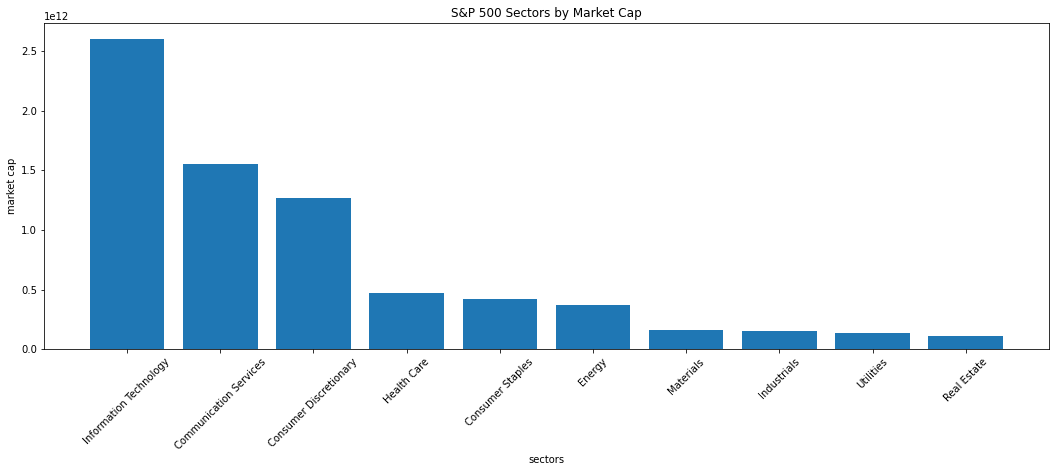

In [234]:
plt.bar(sp_index_combined['sector'], sp_index_combined['market_cap'])
plt.rcParams["figure.figsize"] = [18, 6]
plt.title('S&P 500 Sectors by Market Cap')
plt.ylabel('market cap')
plt.xlabel('sectors')
plt.xticks(rotation = 45)

In [227]:
# Sort by % weight and by sub-sector
sp_index_combined.groupby(by=['subSector','name']).sum().sort_values(by='market_cap', ascending=False).drop(columns=['cik','stock_price','fmp_dcf_calc']).head(10)

market_cap  \
subSector                                  name                               
Technology Hardware, Storage & Peripherals Apple               2.602618e+12   
Systems Software                           Microsoft           2.107441e+12   
Interactive Media & Services               Alphabet (Class C)  1.551770e+12   
                                           Alphabet (Class A)  1.548910e+12   
Internet & Direct Marketing Retail         Amazon              1.264205e+12   
Automobile Manufacturers                   Tesla               9.419921e+11   
Multi-Sector Holdings                      Berkshire Hathaway  7.053954e+11   
Interactive Media & Services               Meta                5.738210e+11   
Semiconductors                             Nvidia              4.884818e+11   
Managed Health Care                        UnitedHealth Group  4.691177e+11   

                                                               margin_of_safety  \
subSector                                  name                                   
Technology Hardware, Storage & Peripherals Apple                       0.012991   
Systems Software                           Microsoft                   0.005480   
Interactive Media & Services               Alphabet (Class C)          0.013104   
                                           Alphabet (Class A)          0.013171   
Internet & Direct Marketing Retail         Amazon                      0.028579   
Automobile Manufacturers                   Tesla                       0.017800   
Multi-Sector Holdings                      Berkshire Hathaway          0.115586   
Interactive Media & Services               Meta                        0.027386   
Semiconductors                             Nvidia                      0.003989   
Managed Health Care                        UnitedHealth Group          0.044519   

                                                               % weight  
subSector                                  name                          
Technology Hardware, Storage & Peripherals Apple               0.066541  
Systems Software                           Microsoft           0.053881  
Interactive Media & Services               Alphabet (Class C)  0.039674  
                                           Alphabet (Class A)  0.039601  
Internet & Direct Marketing Retail         Amazon              0.032322  
Automobile Manufacturers                   Tesla               0.024084  
Multi-Sector Holdings                      Berkshire Hathaway  0.018035  
Interactive Media & Services               Meta                0.014671  
Semiconductors                             Nvidia              0.012489  
Managed Health Care                        UnitedHealth Group  0.011994

In [228]:
# Sort companies by margin of safety. DCF valuation is not a good model to value financial institutions so we should exclude them.
sp_index_combined[sp_index_combined['stock_price'] <= sp_index_combined['fmp_dcf_calc']].sort_values(by='margin_of_safety', ascending=False).head(5) # margin of safety 30%  (some values do not seem reasonable by API calc)

,name,sector,subSector,headQuarter,dateFirstAdded,cik,founded,market_cap,date,stock_price,fmp_dcf_calc,margin_of_safety,% weight
symbol,,,,,,,,,,,,,
STT,State Street,Financials,Asset Management & Custody Banks,"Boston, Massachusetts",None,93751,1792,2.566501e+10,2022-05-04,69.91,365.996740,4.235256,0.000656
NTRS,Northern Trust,Financials,Asset Management & Custody Banks,"Chicago, Illinois",None,73124,1889,2.196534e+10,2022-05-04,105.41,439.018510,3.164866,0.000562
BK,BNY Mellon,Financials,Asset Management & Custody Banks,"New York City, New York",1995-03-31 00:00:00,1390777,1784,3.482417e+10,2022-05-04,43.11,179.058568,3.153527,0.000890
C,Citigroup,Financials,Diversified Banks,"New York City, New York",1988-05-31 00:00:00,831001,1998,9.728919e+10,2022-05-04,50.10,181.011771,2.613009,0.002487
GS,Goldman Sachs,Financials,Investment Banking & Brokerage,"New York City, New York",2002-07-22 00:00:00,886982,1869,1.075694e+11,2022-05-04,314.66,1055.505870,2.354433,0.002750


In [229]:
# Sort companies by margin of safety after excluding financial companies
sp_index_combined = sp_index_combined[sp_index_combined['sector'].str.contains('Financials') == False]
sp_index_combined[sp_index_combined['stock_price'] <= sp_index_combined['fmp_dcf_calc']].sort_values(by='margin_of_safety', ascending=False).head(10)

,name,sector,subSector,headQuarter,dateFirstAdded,cik,founded,market_cap,date,stock_price,fmp_dcf_calc,margin_of_safety,% weight
symbol,,,,,,,,,,,,,
UAL,United Airlines,Industrials,Airlines,"Chicago, Illinois",2015-09-03 00:00:00,100517,1967,1.678744e+10,2022-05-04,51.38,110.008442,1.141075,0.000429
CCL,Carnival,Consumer Discretionary,"Hotels, Resorts & Cruise Lines","Miami, Florida",1998-12-22 00:00:00,815097,1972,2.055827e+10,2022-05-04,17.49,25.449929,0.455113,0.000526
LUV,Southwest Airlines,Industrials,Airlines,"Dallas, Texas",1994-07-01 00:00:00,92380,1967,2.801193e+10,2022-05-04,47.25,67.810132,0.435135,0.000716
DXC,DXC Technology,Information Technology,IT Consulting & Other Services,"Tysons Corner, Virginia",2017-04-04 00:00:00,1688568,2017,7.307447e+09,2022-05-04,29.89,41.568602,0.390719,0.000187
REG,Regency Centers,Real Estate,Retail REITs,"Jacksonville, Florida",2017-03-02 00:00:00,910606,1963,1.180832e+10,2022-05-04,68.60,94.512339,0.377731,0.000302
WYNN,Wynn Resorts,Consumer Discretionary,Casinos & Gaming,"Paradise, Nevada",2008-11-14 00:00:00,1174922,2002,8.310162e+09,2022-05-04,71.69,97.479536,0.359737,0.000212
F,Ford,Consumer Discretionary,Automobile Manufacturers,"Dearborn, Michigan",1957-03-04 00:00:00,37996,1903,5.852785e+10,2022-05-04,14.56,19.729897,0.355075,0.001496
GM,GM,Consumer Discretionary,Automobile Manufacturers,"Detroit, Michigan",2013-06-06 00:00:00,1467858,1908,5.824211e+10,2022-05-04,39.94,53.618937,0.342487,0.001489
PARA,Paramount,Communication Services,Movies & Entertainment,"New York City, New York",None,813828,2019,1.949843e+10,2022-05-04,29.88,40.053701,0.340485,0.000499
